## Семинар 2 "Распознавание рукописных цифр"

ФИО: Фадеев Роман Андреевич

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [28]:
import sys
sys.path.append('./')

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
%matplotlib inline

In [29]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [30]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

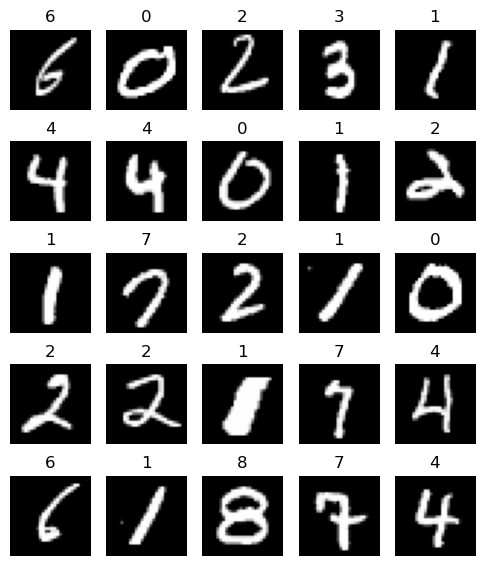

In [31]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [32]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None, train_loader=train_loader, test_loader=test_loader):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [33]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.304/0.299	Accuracy: 0.919/0.921

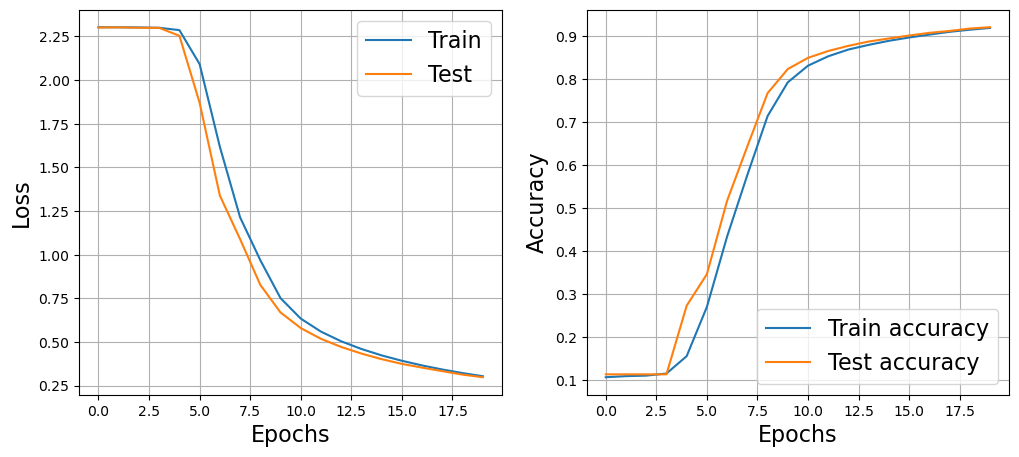

In [34]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [35]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [36]:
# class ReLU:
#     def __init__(self):
#         pass

#     def forward(self, X):
#         '''
#         Passes objects through this layer.
#         X is np.array of size (N, d)
#         '''
#         self.X = X
#         return np.maximum(X, 0)

#     def backward(self, dLdy):
#         '''
#         1. Compute dLdx.
#         2. Return dLdx
#         '''
#         dydX = (self.X >= 0).astype(float)
#         return dLdy*dydX

#     def step(self, learning_rate):
#         pass

In [37]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.035/0.078	Accuracy: 0.991/0.976

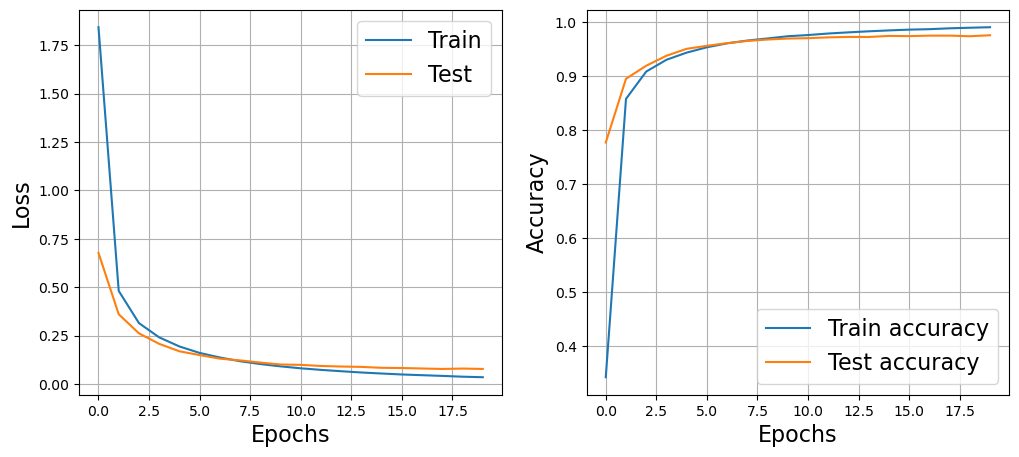

In [38]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.045/0.084	Accuracy: 0.988/0.974

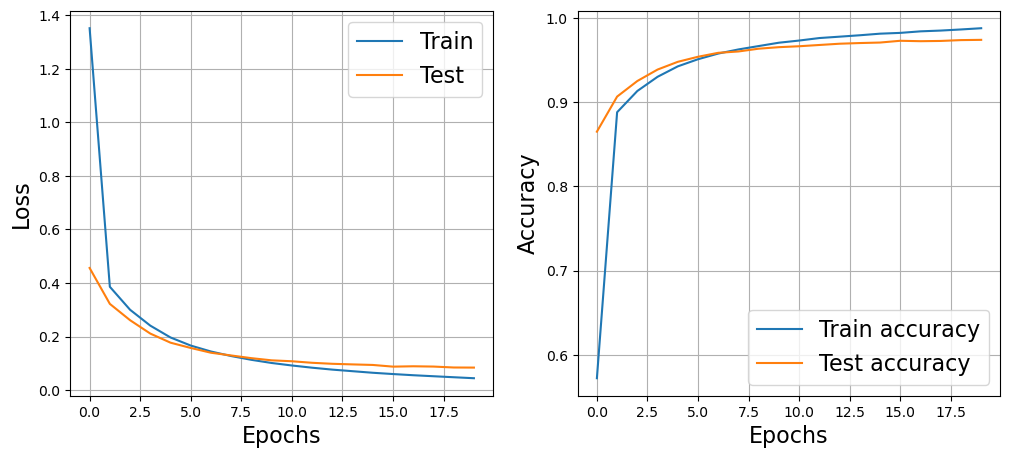

In [39]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

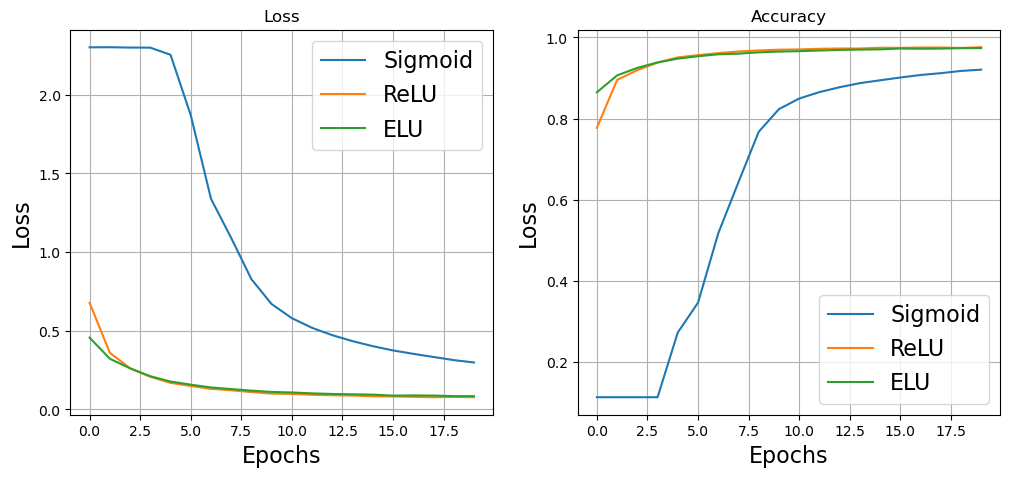

In [40]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### HW1 (1 балл): Реализовать Tanh

In [41]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.t = 2./(1 + np.exp(-2 * X)) - 1
        return self.t
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (1 - self.t**2) * dLdy
    
    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.031/0.081	Accuracy: 0.993/0.975

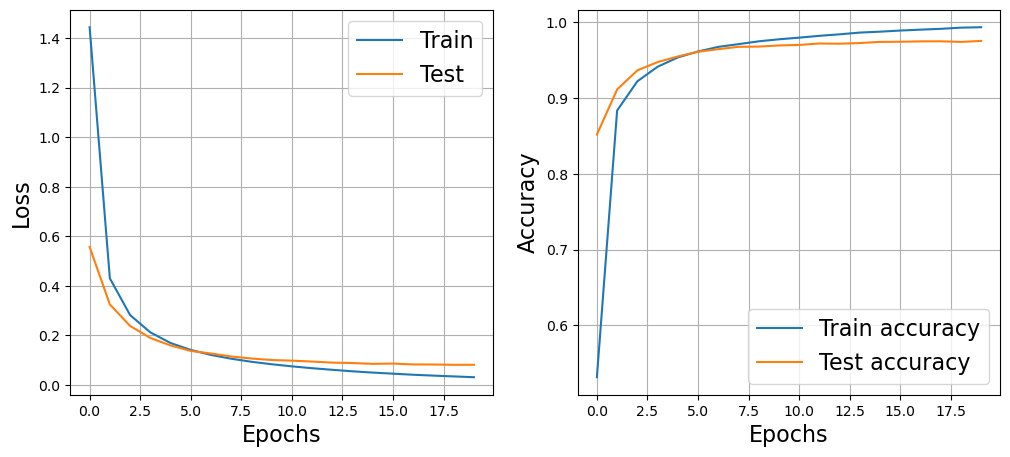

In [42]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_th, ts_th, tr_ac_th, ts_ac_th = train(network, 20, 0.01, plot=True, verbose=True)

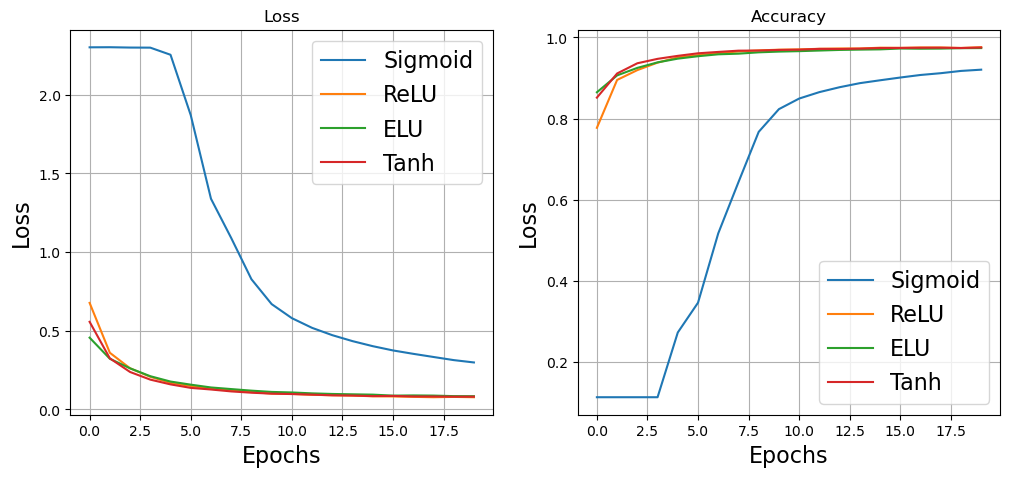

In [43]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_th, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_th, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 3: Анализ ошибок

In [44]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

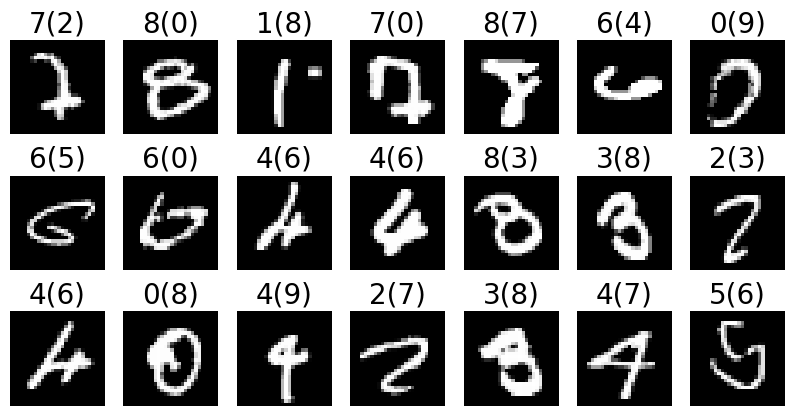

In [45]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

#### Добавление поворота

In [46]:
rotate_transform = transforms.Compose([
                        transforms.RandomRotation(degrees=(-15, 15)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])

rotated_train_dataset  = MNIST('.', train=True, download=True, transform=rotate_transform)
rotated_test_dataset  = MNIST('.', train=False, transform=rotate_transform)

rotated_train_loader = DataLoader(rotated_train_dataset, batch_size=32, shuffle=True)
rotated_test_loader = DataLoader(rotated_test_dataset, batch_size=32, shuffle=False)

Epoch 19... (Train/Test) NLL: 0.066/0.084	Accuracy: 0.980/0.974

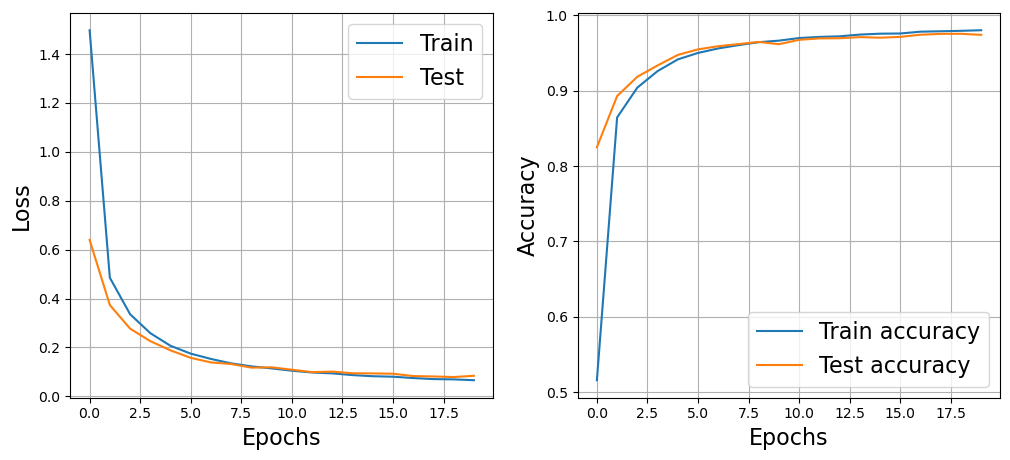

In [47]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
rotate_tr_th, rotate_ts_th, rotate_tr_ac_th, rotate_ts_ac_th = train(
    network, 20, 0.01, 
    plot=True, verbose=True, 
    train_loader=rotated_train_loader, 
    test_loader=rotated_test_loader
)

#### Добавление сдвигов

In [48]:
disp_transform = transforms.Compose([
                        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])

disp_train_dataset  = MNIST('.', train=True, download=True, transform=disp_transform)
disp_test_dataset  = MNIST('.', train=False, transform=disp_transform)

disp_train_loader = DataLoader(disp_train_dataset, batch_size=32, shuffle=True)
disp_test_loader = DataLoader(disp_test_dataset, batch_size=32, shuffle=False)

Epoch 19... (Train/Test) NLL: 0.117/0.120	Accuracy: 0.964/0.963

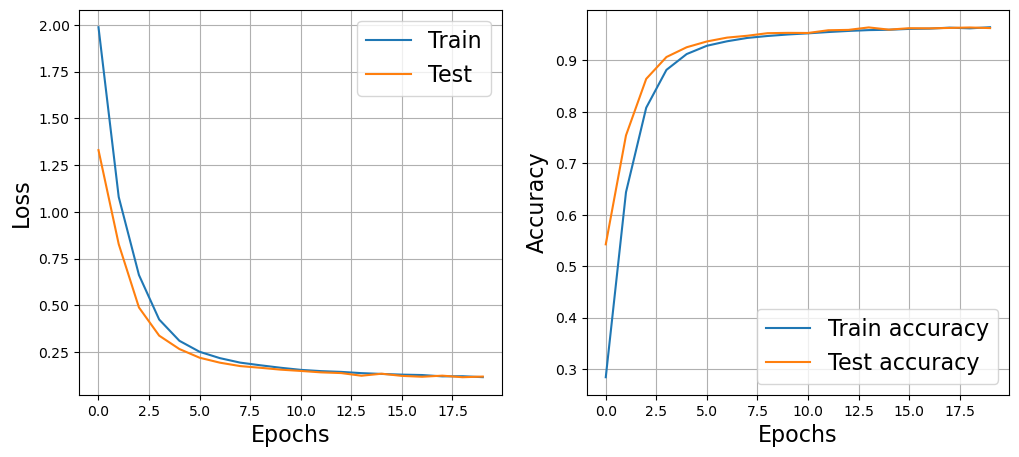

In [49]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
disp_tr_th, disp_ts_th, disp_tr_ac_th, disp_ts_ac_th = train(
    network, 20, 0.01, 
    plot=True, verbose=True, 
    train_loader=disp_train_loader, 
    test_loader=disp_test_loader
)

#### Добавление шума

In [50]:
from PIL import Image

class AddGaussianNoise:
    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        img = np.array(img)
        noise = np.random.normal(self.mean, self.std, img.shape)
        noisy_img = img + noise

        noisy_img = np.clip(noisy_img, 0, 255)
        return Image.fromarray(noisy_img.astype(np.uint8))

In [51]:
gauss_transform = transforms.Compose([
                        AddGaussianNoise(mean=0.0, std=0.1),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])

gauss_train_dataset  = MNIST('.', train=True, download=True, transform=gauss_transform)
gauss_test_dataset  = MNIST('.', train=False, transform=gauss_transform)

gauss_train_loader = DataLoader(gauss_train_dataset, batch_size=32, shuffle=True)
gauss_test_loader = DataLoader(gauss_test_dataset, batch_size=32, shuffle=False)

Epoch 19... (Train/Test) NLL: 0.030/0.077	Accuracy: 0.994/0.976

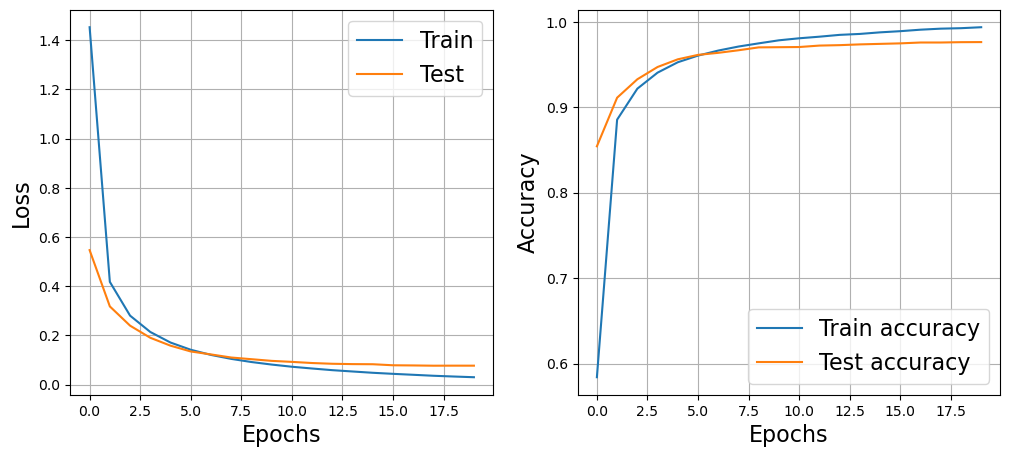

In [52]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
gauss_tr_th, gauss_ts_th, gauss_tr_ac_th, gauss_ts_ac_th = train(
    network, 20, 0.01, 
    plot=True, verbose=True, 
    train_loader=gauss_train_loader, 
    test_loader=gauss_test_loader
)

#### Использование всех изменений для аугментации

In [53]:
mutual_transform = transforms.Compose([
                        transforms.RandomRotation(degrees=(-15, 15)),
                        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                        AddGaussianNoise(mean=0.0, std=0.1),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])

mutual_train_dataset  = MNIST('.', train=True, download=True, transform=mutual_transform)
mutual_test_dataset  = MNIST('.', train=False, transform=mutual_transform)

mutual_train_loader = DataLoader(mutual_train_dataset, batch_size=32, shuffle=True)
mutual_test_loader = DataLoader(mutual_test_dataset, batch_size=32, shuffle=False)

Epoch 19... (Train/Test) NLL: 0.159/0.141	Accuracy: 0.950/0.955

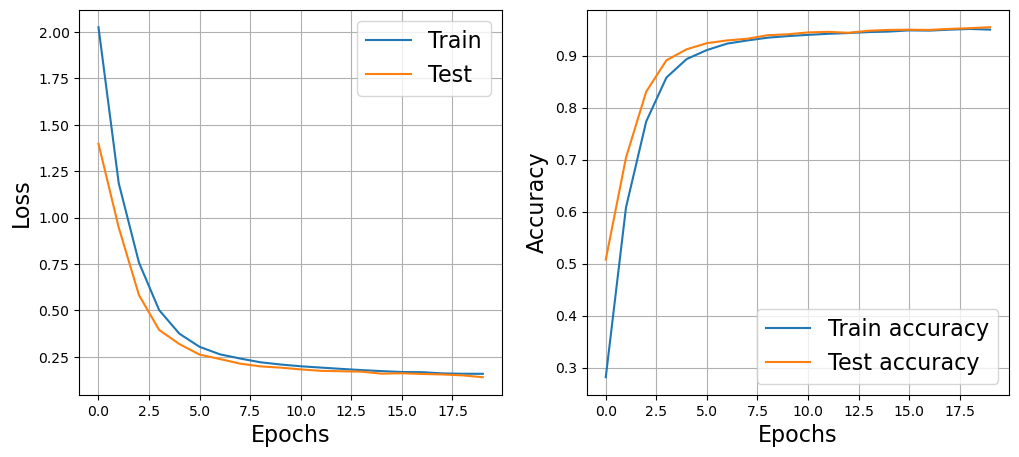

In [54]:
# 0.994/0.978 only tanh

network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
mutual_tr_th, mutual_ts_th, mutual_tr_ac_th, mutual_ts_ac_th = train(
    network, 20, 0.01, 
    plot=True, verbose=True, 
    train_loader=mutual_train_loader, 
    test_loader=mutual_test_loader
)

#### Сравнение всех подходов к аугментации при обучении

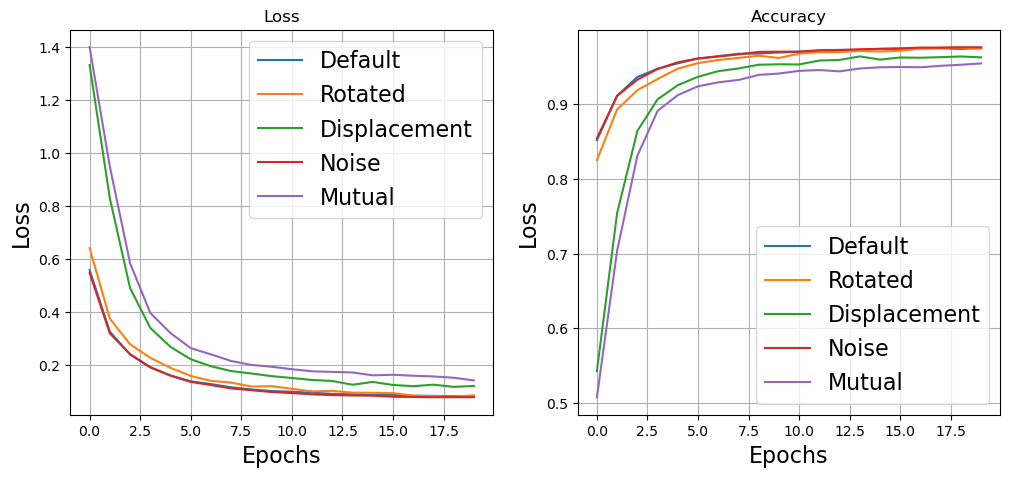

In [56]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_th, label='Default')
plt.plot(rotate_ts_th, label='Rotated')
plt.plot(disp_ts_th, label='Displacement')
plt.plot(gauss_ts_th, label='Noise')
plt.plot(mutual_ts_th, label='Mutual')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_th, label='Default')
plt.plot(rotate_ts_ac_th, label='Rotated')
plt.plot(disp_ts_ac_th, label='Displacement')
plt.plot(gauss_ts_ac_th, label='Noise')
plt.plot(mutual_ts_ac_th, label='Mutual')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Как видно из графиков, нелинейность повысила скорость сходимости модели.

Можно заметить, что при использовании аугментации параметры accuracy для train и test датасетов имеют похожие значения. Значит, модель работает стабильнее, однако общий показатель меньше, чем был без предобработок. Проблема скорее заключается в том, что полносвязная сеть плохо обрабатывает смещения объектов. Также поворот изображения очень зависит от изначального положения. Шум вряд ли может улучшить результат, т.к. датасет состоит из достаточно контрастных и хорошо читаемых изображений.